## Combined Mdoel

In this part of the project, Convolutional Neural Network model is going to be trained using Berst Dataset. The process of training would be the following:
1. Preprocess data:  
    Convert audio file into spectogram image  
    Convert image as grey scale vector or some representation of vector  
2. Train the model
3. Test the model

Before preprocessing, lets import all necessary external libraries. The libraries used are listed below:
1. [librosa](https://librosa.org/doc/main/core.html)
2. [numpy](https://numpy.org/doc/stable/user/index.html)
3. [pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide)
4. [os](https://docs.python.org/3/library/os.html)
5. [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)
6. [classification_report from sklearn.metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)
7. [confusion_matrix from sklearn.metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
8. [keras](https://keras.io/api/)
9. [tensorflow](https://www.tensorflow.org/install) : to use keras, we need tensorflow

In [1]:
#!pip install librosa
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#!pip install tensorflow[and-cuda]
#!pip install --upgrade keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import tensorflow as tf

#### Data Processing
Lets preprocess all the data we used in each models(LSTM, RNN and CNN)
This part is a combination of data processing section in other three jupyter notebook

In [2]:
data = pd.read_csv("../training_set.csv")
data = data[['affect','phone_position','file_path']]
data.head

<bound method NDFrame.head of        affect                                     phone_position  \
0     sadness  Place phone on the opposite side of the room i...   
1     neutral  Hold your phone next to your face but with the...   
2     neutral  Place phone on the opposite side of the room f...   
3     neutral  Place phone on the opposite side of the room f...   
4     disgust  Place phone 1-2 meters away face up on any sur...   
...       ...                                                ...   
2948  sadness  Place phone as far away as possible while on o...   
2949  sadness  Place phone as far away as possible while on o...   
2950  sadness  Place phone as far away as possible while on o...   
2951     fear  Place phone 1-2 meters away face down on a har...   
2952     fear  Place phone 1-2 meters away face down on a har...   

                                              file_path  
0     /dataset/shout_data_3afd7208-7987-4c73-8e01-58...  
1     /dataset/shout_data_ae6feb35-cf

In [3]:
emotion_dict = {"neutral": 0, "anger": 1, "joy":2, "fear":3, "disgust":4, "surprise": 5, "sadness": 6, "Neutral": 0, "Anger": 1, "Joy":2, "Fear":3, "Disgust":4, "Surprise": 5, "Sadness": 6}
position_dict = {"Hold your phone next to your face with the mic facing your mouth as you would in a phone conversation 1/19": 0,
                "Hold your phone next to your face but with the mic/phone facing away from your face 2/19": 1,
                "Hold your phone next to your face with your hand covering the mic 3/19": 2,
                "Hold your phone next to your hip with the back of phone on your palm 4/19": 3,
                "Hold your phone next to your hip with your hand covering the mic 5/19": 4,
                "Place your phone in your pocket 6/19": 5,
                "Place your phone in a bag and hold it next to your hip 7/19": 6,
                "Place phone 1-2 meters away face up on any surface 8/19": 7,
                "Place phone 1-2 meters away face down on a hard surface 9/19": 8,
                "Place phone 1-2 meters away face down on a soft surface 10/19": 9,
                "Place phone 1-2 meters away in a bag 11/19": 10,
                "Place phone on the opposite side of the room face up on any surface 12/19": 11,
                "Place phone on the opposite side of the room face down on a hard surface 13/19": 12,
                "Place phone on the opposite side of the room face down on a soft surface 14/19": 13,
                "Place phone on the opposite side of the room in a bag 15/19": 14,
                "Place phone as far away as possible while on on the opposite side of a wall from you face up on any surface 16/19": 15,
                "Place phone as far away as possible while on on the opposite side of a wall from you face down on a hard surface 17/19": 16,
                "Place phone as far away as possible while on on the opposite side of a wall from you face down on a soft surface 18/19": 17,
                "Place phone as far away as possible while on on the opposite side of a wall from you in a bag 19/19": 18}

In [4]:
#Convert the affect(emotion) and position of the phone(distance) into an integer representation using above dictionary.
data['affect'] = data['affect'].map(emotion_dict)
data['phone_position'] = data['phone_position'].map(position_dict)
data = data.drop(data[data.phone_position.isna()].index)
data['phone_position'] = data['phone_position'].astype('uint8')
data.head

<bound method NDFrame.head of       affect  phone_position  \
0          6              14   
1          0               1   
2          0              12   
3          0              12   
4          4               7   
...      ...             ...   
2948       6              16   
2949       6              16   
2950       6              16   
2951       3               8   
2952       3               8   

                                              file_path  
0     /dataset/shout_data_3afd7208-7987-4c73-8e01-58...  
1     /dataset/shout_data_ae6feb35-cf7a-4805-8d05-03...  
2     /dataset/shout_data_fdb758a5-9c86-40f7-8870-ca...  
3     /dataset/shout_data_fdb758a5-9c86-40f7-8870-ca...  
4     /dataset/shout_data_739dbf1c-ec21-42db-9e49-3a...  
...                                                 ...  
2948  /dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-ef...  
2949  /dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-ef...  
2950  /dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-ef...  
2951 

In [5]:
FRAME_SIZE = 512 # the size of the frame
HOP_LENGTH = 256 # the distance each frame jumps by
FRAME_LENGTH = 512 # length of a frame

def getFeatures(audioSignal, sample_rate):
    
    # duration of 1 sample
    oneSampleDuration = 1/sample_rate
    
    # duration of audio signal in seconds
    sampleDuration = oneSampleDuration*len(audioFile)
    
    ae, time = getAmplitudeEnvelope(audioSignal)
    rms = getRMS(audioSignal)
    zcr = getZCR(audioSignal)
    
    return time, ae, rms, zcr
    
def getAmplitudeEnvelope(audioSignal):
    amplitudeEnvelope = []
    
    for i in range(0, len(audioSignal), HOP_LENGTH):
        currentFrameAE = max(audioSignal[i:i+FRAME_SIZE])
        amplitudeEnvelope.append(currentFrameAE)
        
    amplitudeEnvelope = np.array(amplitudeEnvelope)
    amplitudeFrames = range(0, amplitudeEnvelope.size)
    time = librosa.frames_to_time(amplitudeFrames, hop_length=HOP_LENGTH)
    
    return amplitudeEnvelope, time
    
def getRMS(audioSignal):
    rms = []
    for i in range(0, len(audioSignal), HOP_LENGTH):
        rms_current = np.sqrt(np.sum(audioSignal[i:i+FRAME_LENGTH]**2) / FRAME_LENGTH)
        rms.append(rms_current)
    return rms

def getZCR(audioSignal):
    return librosa.feature.zero_crossing_rate(audioSignal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

def calc_sfb(spec, freq, sr):
    freq_range = sr/2
    freq_delta = freq_range / spec.shape[0]
    return int(np.floor(freq / freq_delta))
def calc_ber(spec, freq, sr):
    sfb = calc_sfb(spec, freq, sr)
    pSpec = np.abs(spec) ** 2
    pSpec = pSpec.T
    ber = []

    for freqs in pSpec:
        sum_low = np.sum(freqs[:sfb])
        sum_high = np.sum(freqs[sfb:])
        ber_current = sum_low/sum_high
        ber.append(ber_current)

    return np.array(ber)
def getFrequencyFeatures(audioSignal, sample_rate):
    audio_spec = librosa.stft(audioFile, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    centroid = librosa.feature.spectral_centroid(y=audioFile, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=audioFile, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    ber = calc_ber(audio_spec, 2000, sample_rate)
    return centroid, bandwidth, ber

In [6]:
#Iterate through each audio clip and get corresponding data
mel_rgb = []
chrom_rgb = []
zeroCrossingRateList = []
amplitudeEnvelopeList = []
rootMeanSquareEnergyList = []
timings = []
spectralCentroidList = []
spectralBandwidthList = []
bandEnergyRatioList = []
audioFileLengths = []

audioFileLengths = []
for fileDir in data['file_path']:
    audioFile, sample_rate = librosa.load('..'+fileDir)
    audioFileLengths.append(len(audioFile))

maxAudioLength = max(audioFileLengths)

for index, row in data.iterrows():
    position = row['phone_position']
    y, sr = librosa.load('..'+row['file_path'])

    #Get Mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    fig, ax = plt.subplots()
    fig.set_size_inches(3,2)
    image = librosa.display.specshow(S_dB, sr=sr,ax=ax)
    fig.canvas.draw()
    
    # Convert the Mel-spectrogram canvas to a raw RGB buffer
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    image = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

    mel_rgb.append(image)
    plt.close()

    # Get Chromagram
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    fig, ax = plt.subplots()
    fig.set_size_inches(3,2)
    image = librosa.display.specshow(chromagram, sr=sr,ax=ax)
    fig.canvas.draw()

    # Convert the chromagram canvas to a raw RGB buffer
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    image = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
    
    chrom_rgb.append(image)
    plt.close()

    # Get Features for LSTM and RNN
    audioFile, sample_rate = librosa.load('..'+row['file_path'])
    audioFile = librosa.util.pad_center(audioFile, size=maxAudioLength)
    centroid, bandwidth, ber = getFrequencyFeatures(audioFile, sample_rate)
    time, ae, rmse, zcr = getFeatures(audioFile, sample_rate)
    zeroCrossingRateList.append(zcr)
    amplitudeEnvelopeList.append(ae)
    rootMeanSquareEnergyList.append(rmse)
    timings.append(time)    
    spectralCentroidList.append(centroid)
    spectralBandwidthList.append(bandwidth)
    bandEnergyRatioList.append(ber)

data['Mel_rgb'] = mel_rgb
data['Chrom_rgb'] = chrom_rgb
data["Timings"] = timings
data["Amplitude_Envelope"] = amplitudeEnvelopeList
data["Root_Mean_Square_Energy"] = rootMeanSquareEnergyList
data["Zero-Crossing_Rate"] = zeroCrossingRateList
data["Spectral Centroid"] = spectralCentroidList
data["Spectral Bandwidth"] = spectralBandwidthList
data["Band Energy Ratio"] = bandEnergyRatioList

data.head()

C:\Users\seungdo\AppData\Local\Temp\ipykernel_4592\1066627661.py:55: RuntimeWarning: invalid value encountered in scalar divide
  ber_current = sum_low/sum_high


,affect,phone_position,file_path,Mel_rgb,Chrom_rgb,Timings,Amplitude_Envelope,Root_Mean_Square_Energy,Zero-Crossing_Rate,Spectral Centroid,Spectral Bandwidth,Band Energy Ratio
0,6,14,/dataset/shout_data_3afd7208-7987-4c73-8e01-58...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,0,1,/dataset/shout_data_ae6feb35-cf7a-4805-8d05-03...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,0,12,/dataset/shout_data_fdb758a5-9c86-40f7-8870-ca...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,0,12,/dataset/shout_data_fdb758a5-9c86-40f7-8870-ca...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,4,7,/dataset/shout_data_739dbf1c-ec21-42db-9e49-3a...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


#### Divide data into training set and validation set
Choose 100 rows from data set and split the data into training set and validation set

In [ ]:
valid = data.sample(n=100)
train = data.drop(valid.index)
print(valid.head)
print(train.head)

#### Test Data
Do the same process for the test data

In [8]:
y_train = train['affect']
y_valid = valid['affect']
y_train = keras.utils.to_categorical(y_train, num_classes=7)
y_valid = keras.utils.to_categorical(y_valid, num_classes=7)
print(y_train.shape)
print(y_valid.shape)

(2847, 7)
(100, 7)


In [9]:
test_data = pd.read_csv("../test_set_annotated.csv")
test_data['file_path'] = test_data["file_name"].str.replace("/media/data/shout-data/", "/dataset/")
test_data['file_path'] = test_data["file_path"].str.replace(".wav", "")
test_data['file_path'] = test_data["file_path"].astype(str) + test_data["chunk_name"].astype(str)
test_data = test_data[['affect','phone_position','file_path','Actual_Determined_Label']]
test_data['affect'] = test_data['affect'].map(emotion_dict)
test_data['Actual_Determined_Label'] = test_data['Actual_Determined_Label'].map(emotion_dict)
test_data['phone_position'] = test_data['phone_position'].map(position_dict)
test_data = test_data.drop(data[data.phone_position.isna()].index)
test_data['phone_position'] = test_data['phone_position'].astype('uint8')
test_data.head

<bound method NDFrame.head of     affect  phone_position                                          file_path  \
0        0              11  /dataset/shout_data_7bdd059c-e54d-442a-8ad9-50...   
1        3               6  /dataset/shout_data_6fd04485-c70a-4b43-8d90-2e...   
2        6               5  /dataset/shout_data_cc0d48c9-104b-4ded-8756-f1...   
3        5               2  /dataset/shout_data_56a9c5f8-62ee-4908-86bd-ae...   
4        2               0  /dataset/shout_data_dcfff758-bcda-4bf9-9872-40...   
..     ...             ...                                                ...   
95       6              17  /dataset/shout_data_fc7be658-3b00-4f7b-88c4-0a...   
96       3              15  /dataset/shout_data_65aaeace-78ad-4c16-9a15-7c...   
97       5               3  /dataset/shout_data_b77f5cd7-34e5-42ec-9c7a-5a...   
98       4               9  /dataset/shout_data_64dfb1bf-af19-40ac-801e-65...   
99       6               7  /dataset/shout_data_dd576092-a5aa-46cb-af97-43...  

In [10]:
#Iterate through each audio clip in test set and get corresponding data
mel_rgb = []
chrom_rgb = []
zeroCrossingRateList = []
amplitudeEnvelopeList = []
rootMeanSquareEnergyList = []
timings = []
spectralCentroidList = []
spectralBandwidthList = []
bandEnergyRatioList = []
audioFileLengths = []

audioFileLengths = []
for fileDir in data['file_path']:
    audioFile, sample_rate = librosa.load('..'+fileDir)
    audioFileLengths.append(len(audioFile))

maxAudioLength = max(audioFileLengths)

for index, row in test_data.iterrows():
    position = row['phone_position']
    y, sr = librosa.load('..'+row['file_path'])

    #Get Mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    fig, ax = plt.subplots()
    fig.set_size_inches(3,2)
    image = librosa.display.specshow(S_dB, sr=sr,ax=ax)
    fig.canvas.draw()
    
    # Convert the mel-spectrogram canvas to a raw RGB buffer
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    image = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

    mel_rgb.append(image)
    plt.close()

    #Get Chromagram
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    fig, ax = plt.subplots()
    fig.set_size_inches(3,2)
    image = librosa.display.specshow(chromagram, sr=sr,ax=ax)
    fig.canvas.draw()

    # Convert the chromagram canvas to a raw RGB buffer
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    image = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
    
    chrom_rgb.append(image)
    plt.close()
   
    # Get Features for LSTM
    audioFile, sample_rate = librosa.load('..'+row['file_path'])
    audioFile = librosa.util.pad_center(audioFile, size=maxAudioLength)
    centroid, bandwidth, ber = getFrequencyFeatures(audioFile, sample_rate)
    time, ae, rmse, zcr = getFeatures(audioFile, sample_rate)
    zeroCrossingRateList.append(zcr)
    amplitudeEnvelopeList.append(ae)
    rootMeanSquareEnergyList.append(rmse)
    timings.append(time)
    spectralCentroidList.append(centroid)
    spectralBandwidthList.append(bandwidth)
    bandEnergyRatioList.append(ber)

test_data['Mel_rgb'] = mel_rgb
test_data['Chrom_rgb'] = chrom_rgb
test_data["Timings"] = timings
test_data["Amplitude_Envelope"] = amplitudeEnvelopeList
test_data["Root_Mean_Square_Energy"] = rootMeanSquareEnergyList
test_data["Zero-Crossing_Rate"] = zeroCrossingRateList
test_data["Spectral Centroid"] = spectralCentroidList
test_data["Spectral Bandwidth"] = spectralBandwidthList
test_data["Band Energy Ratio"] = bandEnergyRatioList

test_data.head()

C:\Users\seungdo\AppData\Local\Temp\ipykernel_4592\1066627661.py:55: RuntimeWarning: invalid value encountered in scalar divide
  ber_current = sum_low/sum_high


,affect,phone_position,file_path,Actual_Determined_Label,Mel_rgb,Chrom_rgb,Timings,Amplitude_Envelope,Root_Mean_Square_Energy,Zero-Crossing_Rate,Spectral Centroid,Spectral Bandwidth,Band Energy Ratio
0,0,11,/dataset/shout_data_7bdd059c-e54d-442a-8ad9-50...,5,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,3,6,/dataset/shout_data_6fd04485-c70a-4b43-8d90-2e...,3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,6,5,/dataset/shout_data_cc0d48c9-104b-4ded-8756-f1...,6,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,5,2,/dataset/shout_data_56a9c5f8-62ee-4908-86bd-ae...,0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,2,0,/dataset/shout_data_dcfff758-bcda-4bf9-9872-40...,2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [11]:
print(test_data['Spectral Centroid'][0].shape)

(639,)


In [12]:
y_test = test_data['affect']
y_test_label = test_data['Actual_Determined_Label']
print(y_test.shape)
print(y_test_label.shape)

(100,)
(100,)


#### CNN and LSTM


In [25]:
#data for CNN
x_train_cnn_mel = np.asarray(train['Mel_rgb'])
x_train_cnn_mel = np.stack(x_train_cnn_mel, axis=0)
x_valid_cnn_mel = np.asarray(valid['Mel_rgb'])
x_valid_cnn_mel = np.stack(x_valid_cnn_mel, axis = 0)
x_test_cnn_mel = np.asarray(test_data['Mel_rgb'])
x_test_cnn_mel = np.stack(x_test_cnn_mel, axis=0)
print(x_train_cnn_mel.shape)
print(x_valid_cnn_mel.shape)
print(x_test_cnn_mel.shape)

#data for LSTM
x_train_lstm = []
for dataCollection in np.array(train[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing_Rate", "Spectral Centroid", "Spectral Bandwidth"]]):
    AE_data, RMS_data, ZCR_data, SC, SB = dataCollection
    x_train_lstm.append([AE_data,RMS_data, ZCR_data, SC, SB])
x_train_lstm = np.asarray(x_train_lstm)
print("training data shape: {}".format(x_train_lstm.shape))

x_valid_lstm = []
for dataCollection in np.array(valid[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing_Rate", "Spectral Centroid", "Spectral Bandwidth"]]):
    AE_data, RMS_data, ZCR_data, SC, SB = dataCollection
    x_valid_lstm.append([AE_data,RMS_data, ZCR_data, SC, SB])
x_valid_lstm = np.array(x_valid_lstm)
print("valid data shape: {}".format(x_valid_lstm.shape))

x_test_lstm = []
for dataCollection in np.array(test_data[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing_Rate", "Spectral Centroid", "Spectral Bandwidth"]]):
    AE_data, RMS_data, ZCR_data, SC, SB = dataCollection
    x_test_lstm.append([AE_data,RMS_data, ZCR_data, SC, SB])
x_test_lstm = np.array(x_test_lstm)
print("test data shape: {}".format(x_test_lstm.shape))

(2847, 200, 300, 3)
(100, 200, 300, 3)
(100, 200, 300, 3)
training data shape: (2847, 5, 639)
valid data shape: (100, 5, 639)
test data shape: (100, 5, 639)


In [34]:
#CNN model
CNNInput = keras.layers.Input(shape=(200, 300, 3))
CNNModel = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(CNNInput)
CNNModel = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(CNNModel)
CNNModel = keras.layers.BatchNormalization()(CNNModel)
CNNModel = keras.layers.MaxPooling2D(pool_size=(2, 2))(CNNModel)
CNNModel = keras.layers.Dropout(0.10)(CNNModel)
CNNModel = keras.layers.Flatten()(CNNModel)

#LSTM model
data_dimension = 5
timesteps = len(data["Timings"][0])
numberClasses = 7

LSTMInput = keras.layers.Input(shape=(data_dimension, timesteps))
LSTMModel = keras.layers.LSTM(64, return_sequences=True)(LSTMInput)
LSTMModel = keras.layers.LSTM(32, return_sequences=True)(LSTMModel)
LSTMModel = keras.layers.LSTM(32)(LSTMModel)
LSTMModel = keras.layers.Dropout(0.1)(LSTMModel)

#Merge two models
Merge = keras.layers.concatenate([CNNModel, LSTMModel])

Output = keras.layers.Dense(numberClasses, activation="softmax")(Merge)

CNN_LSTM_model = keras.Model(inputs=[CNNInput, LSTMInput], outputs=Output)
CNN_LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN_LSTM_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 198, 298, 64  1792        ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 196, 296, 32  18464       ['conv2d_14[0][0]']              
                                )                                                           

In [18]:
y_train_tensor = tf.convert_to_tensor(y_train)
y_valid_tensor = tf.convert_to_tensor(y_valid)

x_train_cnn_tensor = tf.convert_to_tensor(x_train_cnn_mel)
x_valid_cnn_tensor = tf.convert_to_tensor(x_valid_cnn_mel)
x_train_lstm_tensor = tf.convert_to_tensor(x_train_lstm)
x_valid_lstm_tensor = tf.convert_to_tensor(x_valid_lstm)

CNN_LSTM_model.fit([x_train_cnn_tensor, x_train_lstm_tensor], y_train_tensor, batch_size=16, epochs=15, validation_data=([x_valid_cnn_tensor, x_valid_lstm_tensor], y_valid_tensor))

Epoch 1/15
178/178 [==============================] - 10s 39ms/step - loss: 25.2954 - accuracy: 0.1661 - val_loss: 14.5427 - val_accuracy: 0.1200
Epoch 2/15
178/178 [==============================] - 6s 35ms/step - loss: 7.6741 - accuracy: 0.3063 - val_loss: 21.0166 - val_accuracy: 0.1600
Epoch 3/15
178/178 [==============================] - 6s 36ms/step - loss: 3.7365 - accuracy: 0.6063 - val_loss: 10.4357 - val_accuracy: 0.2200
Epoch 4/15
178/178 [==============================] - 6s 35ms/step - loss: 1.4809 - accuracy: 0.8044 - val_loss: 10.4315 - val_accuracy: 0.2100
Epoch 5/15
178/178 [==============================] - 6s 35ms/step - loss: 0.8927 - accuracy: 0.8785 - val_loss: 16.4589 - val_accuracy: 0.2000
Epoch 6/15
178/178 [==============================] - 6s 35ms/step - loss: 1.2213 - accuracy: 0.8841 - val_loss: 28.5606 - val_accuracy: 0.1900
Epoch 7/15
178/178 [==============================] - 6s 35ms/step - loss: 1.1007 - accuracy: 0.8960 - val_loss: 27.6394 - val_accurac

4/4 [==============================] - 1s 12ms/step
Accuracy:  0.22
              precision    recall  f1-score   support

           0       0.17      0.09      0.12        22
           1       0.25      0.28      0.26        25
           2       0.40      0.24      0.30        17
           3       0.27      0.33      0.30         9
           4       0.12      0.14      0.13         7
           5       0.29      0.33      0.31        12
           6       0.06      0.12      0.08         8

    accuracy                           0.22       100
   macro avg       0.22      0.22      0.21       100
weighted avg       0.24      0.22      0.22       100



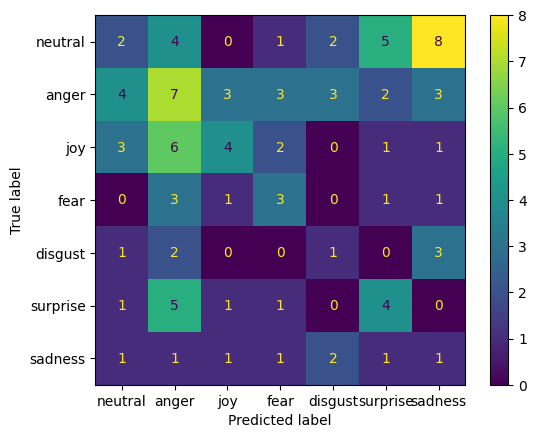

In [19]:
prediction = CNN_LSTM_model.predict([x_test_cnn_mel, x_test_lstm])
prediction = np.argmax(prediction, axis=1)

accuracy = np.mean(prediction == y_test_label)
print("Accuracy: ", accuracy)
print(classification_report(y_test_label, prediction,zero_division=0))
confusion = confusion_matrix(y_test_label, prediction)
display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = ["neutral", "anger", "joy", "fear", "disgust", "surprise", "sadness"])
display.plot()
plt.show()

In [22]:
x_train_cnn_chrom = np.asarray(train['Chrom_rgb'])
x_train_cnn_chrom = np.stack(x_train_cnn_chrom, axis=0)
x_valid_cnn_chrom = np.asarray(valid['Chrom_rgb'])
x_valid_cnn_chrom = np.stack(x_valid_cnn_chrom, axis = 0)
x_test_cnn_chrom = np.asarray(test_data['Chrom_rgb'])
x_test_cnn_chrom = np.stack(x_test_cnn_chrom, axis=0)
print(x_train_cnn_chrom.shape)
print(x_valid_cnn_chrom.shape)
print(x_test_cnn_chrom.shape)

(2847, 200, 300, 3)
(100, 200, 300, 3)
(100, 200, 300, 3)


In [35]:
#CNN model
CNNInput = keras.layers.Input(shape=(200, 300, 3))
CNNModel = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(CNNInput)
CNNModel = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(CNNModel)
CNNModel = keras.layers.BatchNormalization()(CNNModel)
CNNModel = keras.layers.MaxPooling2D(pool_size=(2, 2))(CNNModel)
CNNModel = keras.layers.Dropout(0.10)(CNNModel)
CNNModel = keras.layers.Flatten()(CNNModel)

#LSTM model
data_dimension = 5
timesteps = len(data["Timings"][0])
numberClasses = 7

LSTMInput = keras.layers.Input(shape=(data_dimension, timesteps))
LSTMModel = keras.layers.LSTM(64, return_sequences=True)(LSTMInput)
LSTMModel = keras.layers.LSTM(32, return_sequences=True)(LSTMModel)
LSTMModel = keras.layers.LSTM(32)(LSTMModel)
LSTMModel = keras.layers.Dropout(0.1)(LSTMModel)

#Merge two models
Merge = keras.layers.concatenate([CNNModel, LSTMModel])

Output = keras.layers.Dense(numberClasses, activation="softmax")(Merge)

CNN_LSTM_model2 = keras.Model(inputs=[CNNInput, LSTMInput], outputs=Output)
CNN_LSTM_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN_LSTM_model2.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 198, 298, 64  1792        ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 196, 296, 32  18464       ['conv2d_16[0][0]']              
                                )                                                           

In [32]:
y_train_tensor = tf.convert_to_tensor(y_train)
y_valid_tensor = tf.convert_to_tensor(y_valid)

x_train_cnn_tensor = tf.convert_to_tensor(x_train_cnn_chrom)
x_valid_cnn_tensor = tf.convert_to_tensor(x_valid_cnn_chrom)
x_train_lstm_tensor = tf.convert_to_tensor(x_train_lstm)
x_valid_lstm_tensor = tf.convert_to_tensor(x_valid_lstm)

CNN_LSTM_model2.fit([x_train_cnn_tensor, x_train_lstm_tensor], y_train_tensor, batch_size=16, epochs=15, validation_data=([x_valid_cnn_tensor, x_valid_lstm_tensor], y_valid_tensor))

Epoch 1/15
178/178 [==============================] - 10s 41ms/step - loss: 25.8859 - accuracy: 0.1528 - val_loss: 42.8462 - val_accuracy: 0.1200
Epoch 2/15
178/178 [==============================] - 6s 35ms/step - loss: 11.2948 - accuracy: 0.2859 - val_loss: 35.9962 - val_accuracy: 0.1900
Epoch 3/15
178/178 [==============================] - 6s 36ms/step - loss: 9.0286 - accuracy: 0.4608 - val_loss: 35.2484 - val_accuracy: 0.1400
Epoch 4/15
178/178 [==============================] - 6s 36ms/step - loss: 4.4746 - accuracy: 0.6740 - val_loss: 79.5629 - val_accuracy: 0.1300
Epoch 5/15
178/178 [==============================] - 6s 36ms/step - loss: 1.9580 - accuracy: 0.8093 - val_loss: 23.4589 - val_accuracy: 0.1900
Epoch 6/15
178/178 [==============================] - 6s 35ms/step - loss: 0.8015 - accuracy: 0.9083 - val_loss: 19.6453 - val_accuracy: 0.1700
Epoch 7/15
178/178 [==============================] - 6s 36ms/step - loss: 0.5174 - accuracy: 0.9392 - val_loss: 23.4548 - val_accura

4/4 [==============================] - 1s 11ms/step
Accuracy:  0.17
              precision    recall  f1-score   support

           0       0.33      0.23      0.27        22
           1       0.44      0.28      0.34        25
           2       0.06      0.06      0.06        17
           3       0.00      0.00      0.00         9
           4       0.10      0.29      0.15         7
           5       0.10      0.17      0.12        12
           6       0.00      0.00      0.00         8

    accuracy                           0.17       100
   macro avg       0.15      0.15      0.13       100
weighted avg       0.21      0.17      0.18       100



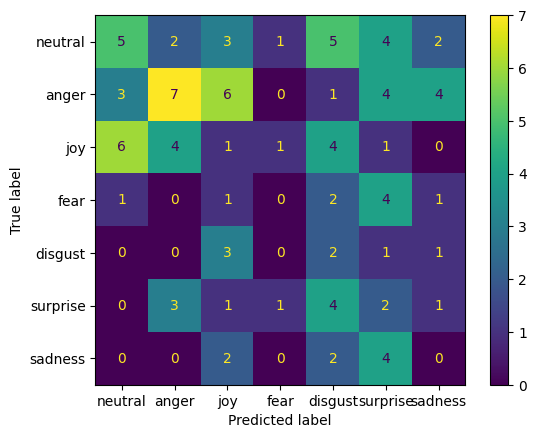

In [33]:
prediction = CNN_LSTM_model2.predict([x_test_cnn_chrom, x_test_lstm])
prediction = np.argmax(prediction, axis=1)

accuracy = np.mean(prediction == y_test_label)
print("Accuracy: ", accuracy)
print(classification_report(y_test_label, prediction,zero_division=0))
confusion = confusion_matrix(y_test_label, prediction)
display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = ["neutral", "anger", "joy", "fear", "disgust", "surprise", "sadness"])
display.plot()
plt.show()

#### CNN and RNN

In [46]:
#CNN model
CNNInput = keras.layers.Input(shape=(200, 300, 3))
CNNModel = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(CNNInput)
CNNModel = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(CNNModel)
CNNModel = keras.layers.BatchNormalization()(CNNModel)
CNNModel = keras.layers.MaxPooling2D(pool_size=(2, 2))(CNNModel)
CNNModel = keras.layers.Dropout(0.10)(CNNModel)
CNNModel = keras.layers.Flatten()(CNNModel)

#RNN Model
RNNInput = keras.layers.Input(shape=(5, len(data["Timings"][0])))
RNNModel = keras.layers.SimpleRNN(250, return_sequences=True)(RNNInput)
RNNModel = keras.layers.SimpleRNN(100, return_sequences=True)(RNNModel)
RNNModel = keras.layers.SimpleRNN(25)(RNNModel)
RNNModel = keras.layers.Dropout(0.01)(RNNModel)

#Merge two models
Merge = keras.layers.concatenate([CNNModel, RNNModel])

Output = keras.layers.Dense(numberClasses, activation="softmax")(Merge)

CNN_RNN_model = keras.Model(inputs=[CNNInput, RNNInput], outputs=Output)
CNN_RNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN_RNN_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 198, 298, 64  1792        ['input_27[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 196, 296, 32  18464       ['conv2d_28[0][0]']              
                                )                                                          

In [47]:
y_train_tensor = tf.convert_to_tensor(y_train)
y_valid_tensor = tf.convert_to_tensor(y_valid)

x_train_cnn_tensor = tf.convert_to_tensor(x_train_cnn_mel)
x_valid_cnn_tensor = tf.convert_to_tensor(x_valid_cnn_mel)
x_train_rnn_tensor = tf.convert_to_tensor(x_train_lstm)
x_valid_rnn_tensor = tf.convert_to_tensor(x_valid_lstm)

CNN_RNN_model.fit([x_train_cnn_tensor, x_train_rnn_tensor], y_train_tensor, batch_size=16, epochs=15, validation_data=([x_valid_cnn_tensor, x_valid_rnn_tensor], y_valid_tensor))

Epoch 1/15
178/178 [==============================] - 9s 43ms/step - loss: 46.6903 - accuracy: 0.1700 - val_loss: 27.9251 - val_accuracy: 0.1500
Epoch 2/15
178/178 [==============================] - 7s 40ms/step - loss: 25.3615 - accuracy: 0.2547 - val_loss: 16.3109 - val_accuracy: 0.2200
Epoch 3/15
178/178 [==============================] - 7s 41ms/step - loss: 10.9282 - accuracy: 0.5515 - val_loss: 351.8750 - val_accuracy: 0.1200
Epoch 4/15
178/178 [==============================] - 7s 41ms/step - loss: 10.5992 - accuracy: 0.6660 - val_loss: 36.9756 - val_accuracy: 0.2400
Epoch 5/15
178/178 [==============================] - 7s 41ms/step - loss: 3.4932 - accuracy: 0.8440 - val_loss: 48.9351 - val_accuracy: 0.1900
Epoch 6/15
178/178 [==============================] - 7s 42ms/step - loss: 2.2845 - accuracy: 0.8897 - val_loss: 43.9068 - val_accuracy: 0.2000
Epoch 7/15
178/178 [==============================] - 7s 42ms/step - loss: 1.3699 - accuracy: 0.9350 - val_loss: 51.6131 - val_accu

4/4 [==============================] - 0s 111ms/step
Accuracy:  0.22
              precision    recall  f1-score   support

           0       0.22      0.55      0.32        22
           1       0.00      0.00      0.00        25
           2       0.33      0.24      0.28        17
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         7
           5       0.22      0.33      0.27        12
           6       0.22      0.25      0.24         8

    accuracy                           0.22       100
   macro avg       0.14      0.19      0.16       100
weighted avg       0.15      0.22      0.17       100



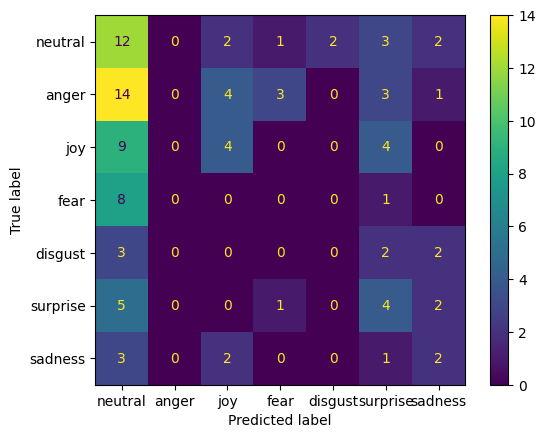

In [60]:
prediction = CNN_RNN_model.predict([x_test_cnn_mel, x_test_lstm])
prediction = np.argmax(prediction, axis=1)

accuracy = np.mean(prediction == y_test_label)
print("Accuracy: ", accuracy)
print(classification_report(y_test_label, prediction,zero_division=0))
confusion = confusion_matrix(y_test_label, prediction)
display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = ["neutral", "anger", "joy", "fear", "disgust", "surprise", "sadness"])
display.plot()
plt.show()

In [57]:
#CNN model
CNNInput = keras.layers.Input(shape=(200, 300, 3))
CNNModel = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(CNNInput)
CNNModel = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(CNNModel)
CNNModel = keras.layers.BatchNormalization()(CNNModel)
CNNModel = keras.layers.MaxPooling2D(pool_size=(2, 2))(CNNModel)
CNNModel = keras.layers.Dropout(0.10)(CNNModel)
CNNModel = keras.layers.Flatten()(CNNModel)

#RNN Model
RNNInput = keras.layers.Input(shape=(5, len(data["Timings"][0])))
RNNModel = keras.layers.SimpleRNN(250, return_sequences=True)(RNNInput)
RNNModel = keras.layers.SimpleRNN(100, return_sequences=True)(RNNModel)
RNNModel = keras.layers.SimpleRNN(25)(RNNModel)
RNNModel = keras.layers.Dropout(0.01)(RNNModel)

#Merge two models
Merge = keras.layers.concatenate([CNNModel, RNNModel])

Output = keras.layers.Dense(numberClasses, activation="softmax")(Merge)

CNN_RNN_model2 = keras.Model(inputs=[CNNInput, RNNInput], outputs=Output)
CNN_RNN_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN_RNN_model2.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 198, 298, 64  1792        ['input_35[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 196, 296, 32  18464       ['conv2d_34[0][0]']              
                                )                                                          

In [58]:
y_train_tensor = tf.convert_to_tensor(y_train)
y_valid_tensor = tf.convert_to_tensor(y_valid)

x_train_cnn_tensor = tf.convert_to_tensor(x_train_cnn_chrom)
x_valid_cnn_tensor = tf.convert_to_tensor(x_valid_cnn_chrom)
x_train_rnn_tensor = tf.convert_to_tensor(x_train_lstm)
x_valid_rnn_tensor = tf.convert_to_tensor(x_valid_lstm)

CNN_RNN_model2.fit([x_train_cnn_tensor, x_train_rnn_tensor], y_train_tensor, batch_size=16, epochs=15, validation_data=([x_valid_cnn_tensor, x_valid_rnn_tensor], y_valid_tensor))

Epoch 1/15
178/178 [==============================] - 9s 43ms/step - loss: 31.5943 - accuracy: 0.1700 - val_loss: 40.5178 - val_accuracy: 0.1900
Epoch 2/15
178/178 [==============================] - 7s 41ms/step - loss: 13.9794 - accuracy: 0.2757 - val_loss: 105.8227 - val_accuracy: 0.1900
Epoch 3/15
178/178 [==============================] - 7s 41ms/step - loss: 8.7957 - accuracy: 0.4373 - val_loss: 74.8565 - val_accuracy: 0.1200
Epoch 4/15
178/178 [==============================] - 8s 43ms/step - loss: 5.6690 - accuracy: 0.5996 - val_loss: 31.2638 - val_accuracy: 0.2200
Epoch 5/15
178/178 [==============================] - 7s 40ms/step - loss: 3.7484 - accuracy: 0.7352 - val_loss: 29.8858 - val_accuracy: 0.1500
Epoch 6/15
178/178 [==============================] - 7s 41ms/step - loss: 2.3050 - accuracy: 0.8128 - val_loss: 44.5125 - val_accuracy: 0.1700
Epoch 7/15
178/178 [==============================] - 7s 41ms/step - loss: 1.6327 - accuracy: 0.8641 - val_loss: 35.0855 - val_accura

4/4 [==============================] - 0s 16ms/step
Accuracy:  0.05
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        25
           2       0.14      0.06      0.08        17
           3       0.00      0.00      0.00         9
           4       0.03      0.14      0.06         7
           5       0.00      0.00      0.00        12
           6       0.05      0.38      0.09         8

    accuracy                           0.05       100
   macro avg       0.03      0.08      0.03       100
weighted avg       0.03      0.05      0.03       100



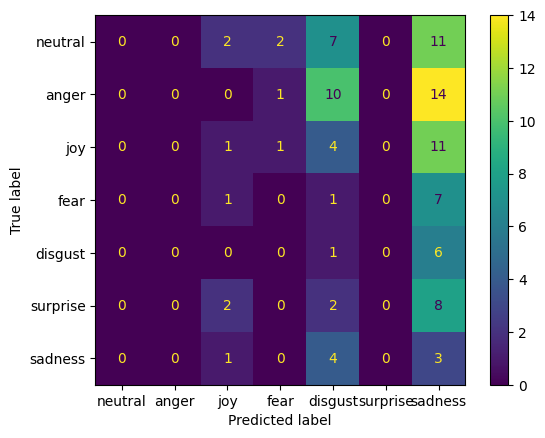

In [59]:
prediction = CNN_RNN_model2.predict([x_test_cnn_chrom, x_test_lstm])
prediction = np.argmax(prediction, axis=1)

accuracy = np.mean(prediction == y_test_label)
print("Accuracy: ", accuracy)
print(classification_report(y_test_label, prediction,zero_division=0))
confusion = confusion_matrix(y_test_label, prediction)
display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = ["neutral", "anger", "joy", "fear", "disgust", "surprise", "sadness"])
display.plot()
plt.show()

#### LSTM and RNN

In [52]:
#LSTM model
data_dimension = 5
timesteps = len(data["Timings"][0])
numberClasses = 7

LSTMInput = keras.layers.Input(shape=(data_dimension, timesteps))
LSTMModel = keras.layers.LSTM(64, return_sequences=True)(LSTMInput)
LSTMModel = keras.layers.LSTM(32, return_sequences=True)(LSTMModel)
LSTMModel = keras.layers.LSTM(32)(LSTMModel)
LSTMModel = keras.layers.Dropout(0.1)(LSTMModel)

#RNN Model
RNNInput = keras.layers.Input(shape=(5, len(data["Timings"][0])))
RNNModel = keras.layers.SimpleRNN(250, return_sequences=True)(RNNInput)
RNNModel = keras.layers.SimpleRNN(100, return_sequences=True)(RNNModel)
RNNModel = keras.layers.SimpleRNN(25)(RNNModel)
RNNModel = keras.layers.Dropout(0.01)(RNNModel)

#Merge two models
Merge = keras.layers.concatenate([LSTMModel, RNNModel])

Output = keras.layers.Dense(numberClasses, activation="softmax")(Merge)

LSTM_RNN_model = keras.Model(inputs=[LSTMInput, RNNInput], outputs=Output)
LSTM_RNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_RNN_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 5, 639)]     0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 5, 639)]     0           []                               
                                                                                                  
 lstm_27 (LSTM)                 (None, 5, 64)        180224      ['input_31[0][0]']               
                                                                                                  
 simple_rnn_15 (SimpleRNN)      (None, 5, 250)       222500      ['input_32[0][0]']               
                                                                                           

4/4 [==============================] - 1s 6ms/step
Accuracy:  0.17
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.35      0.24      0.29        25
           2       0.21      0.18      0.19        17
           3       0.20      0.11      0.14         9
           4       0.13      0.86      0.23         7
           5       0.00      0.00      0.00        12
           6       0.05      0.12      0.07         8

    accuracy                           0.17       100
   macro avg       0.14      0.22      0.13       100
weighted avg       0.16      0.17      0.14       100



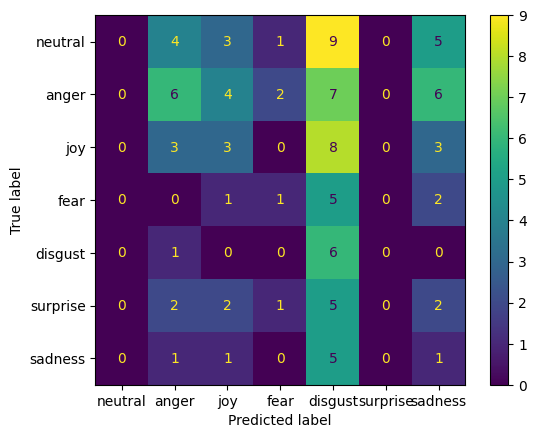

In [53]:
prediction = LSTM_RNN_model.predict([x_test_lstm, x_test_lstm])
prediction = np.argmax(prediction, axis=1)

accuracy = np.mean(prediction == y_test_label)
print("Accuracy: ", accuracy)
print(classification_report(y_test_label, prediction,zero_division=0))
confusion = confusion_matrix(y_test_label, prediction)
display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = ["neutral", "anger", "joy", "fear", "disgust", "surprise", "sadness"])
display.plot()
plt.show()